# Portfolio Optimization using Markowitz & Black-Litterman Model 

#### Mathematical symbols used in this notebook

| Python symbol | Math Symbol | Comment
| -- | -- | --
| rf | $r$ | risk free rate
| lambdaa | $\lambda$ | risk aversion coefficient
| C | $C$ | Assets covariance matrix
| V | $V$ | Assets variances (diagonal in covariance matrix)
| W | $W$ | Assets weights
| R | $R$ | Assets returns
| mean | $\mu$ | Portfolio historical return
| var | $\sigma$ | Portfolio historical variance
| Pi | $\Pi$ | Portfolio equilibrium excess returns
| tau | $\tau$ | Scaling factor for Black-litterman

## Importing all the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib_inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas_datareader import data as web
import yfinance as yf
from pytickersymbols import PyTickerSymbols
from collections import defaultdict
from IPython.core.display import HTML
import seaborn as sns

## Load Historical Prices

In [3]:
stock_data = PyTickerSymbols()
stocks_list = stock_data.get_dow_jones_nyc_yahoo_tickers()
stocks_list.remove('DOW')
len(stocks_list)

30

In [4]:
tickers = yf.Tickers(stocks_list)
market_cap = {}
for str in stocks_list:
    market_cap[str] = tickers.tickers[str].info['marketCap']

In [5]:
# Function loads historical stock prices of Dow Jones companies and returns them together
# with their market capitalizations
def load_data():
    symbols = stocks_list
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        file_name = 'dow-jones/{}.csv'.format(s)
        dataframe = pd.read_csv(file_name, index_col = None, parse_dates = ['date'])
        prices = list(dataframe['close'])[-2000:] # trailing window 2000 days
        prices_out.append(prices)
        caps_out.append(market_cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
prices = np.array(prices)

In [6]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def daily_asset_estimator(prices):
    prices = np.matrix(prices)
    r, c = prices.shape
    historical_returns = np.empty([r, c-1])
    for ri in range(r):
        for ci in range(c-1):
            prior_price, after_price = prices[ri, ci], prices[ri, ci+1]
            historical_returns[ri, ci] = (after_price/prior_price)-1
    expected_returns = np.array([])
    for ri in range(r):
        expected_returns = np.append(expected_returns, np.mean(historical_returns[ri]))
    covariance = np.cov(historical_returns)
    expected_returns = (1 + expected_returns) ** 253 - 1
    print(expected_returns)
    covariance = covariance * 253
    return expected_returns, covariance

W = np.array(caps)/sum(caps)
R, C = daily_asset_estimator(prices)
rf = 0.04

[-0.01144246  0.13050705  0.26890742  0.1439121   0.19321497  0.12237646
  0.10666349  0.0689206   0.00243911  0.13407429  0.18655996  0.02430892
  0.01390944  0.09051328  0.16149544  0.17311685  0.16978298  0.1083858
  0.2784555   0.08841264  0.10708715  0.2611366  -0.00488098  0.19970223
  0.0877617  -0.0433758   0.02970237  0.09900692  0.13635095  0.18053157]


In [7]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index = names).T)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Return,-0.011442,0.130507,0.268907,0.143912,0.193215,0.122376,0.106663,0.068921,0.002439,0.134074,...,0.107087,0.261137,-0.004881,0.199702,0.087762,-0.043376,0.029702,0.099007,0.136351,0.180532
Weight (based on market cap),0.005071,0.010397,0.246396,0.011076,0.010053,0.027494,0.017358,0.025001,0.005759,0.009847,...,0.003871,0.041638,0.014404,0.044555,0.037697,0.002474,0.017024,0.011424,0.011968,0.017963


In [8]:
display(pd.DataFrame(C, columns = names, index = names))

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
MMM,0.055897,0.039174,0.031579,0.042788,0.043300,0.034382,0.034069,0.022624,0.006757,0.039718,...,0.028347,0.027373,0.017114,0.031818,0.015756,0.033036,0.030753,0.025497,0.038469,0.028694
AXP,0.039174,0.104041,0.042416,0.084695,0.054724,0.059214,0.042019,0.030499,0.015761,0.067892,...,0.046258,0.042534,0.019593,0.055715,0.015863,0.039562,0.054623,0.028412,0.052728,0.044939
AAPL,0.031579,0.042416,0.090092,0.053649,0.037249,0.033456,0.044865,0.022008,0.010720,0.044910,...,0.026348,0.036470,0.015571,0.046754,0.022447,0.031405,0.038657,0.032186,0.036347,0.058495
BA,0.042788,0.084695,0.053649,0.180866,0.065874,0.069319,0.046188,0.034666,0.019982,0.072344,...,0.049867,0.043184,0.021004,0.056517,0.017608,0.045492,0.062519,0.026154,0.063806,0.053515
CAT,0.043300,0.054724,0.037249,0.065874,0.092588,0.056385,0.039423,0.022996,0.007912,0.056513,...,0.035689,0.030959,0.018681,0.039360,0.016887,0.037447,0.039993,0.029018,0.047190,0.035808
CVX,0.034382,0.059214,0.033456,0.069319,0.056385,0.098968,0.036179,0.026105,0.015575,0.054813,...,0.041980,0.036851,0.020538,0.040876,0.014919,0.033364,0.040669,0.025050,0.045238,0.033402
CSCO,0.034069,0.042019,0.044865,0.046188,0.039423,0.036179,0.069813,0.022541,0.007851,0.041495,...,0.028715,0.031833,0.019011,0.039867,0.022125,0.034347,0.037339,0.030157,0.037037,0.045284
KO,0.022624,0.030499,0.022008,0.034666,0.022996,0.026105,0.022541,0.035790,0.007151,0.024608,...,0.025022,0.021990,0.017626,0.025259,0.015450,0.022012,0.024100,0.018433,0.026204,0.020488
GS-PK,0.006757,0.015761,0.010720,0.019982,0.007912,0.015575,0.007851,0.007151,0.015184,0.011842,...,0.010446,0.011223,0.004445,0.012079,0.002321,0.004443,0.009821,0.006080,0.011589,0.011672
GS,0.039718,0.067892,0.044910,0.072344,0.056513,0.054813,0.041495,0.024608,0.011842,0.088923,...,0.043367,0.038702,0.019333,0.046613,0.017745,0.039339,0.048443,0.030524,0.047478,0.044902


In [9]:
# #plotting covariance
# df = pd.DataFrame(C, columns = names, index = names)
# colormap = sns.color_palette("coolwarm")
# ax = sns.heatmap(df, cmap = colormap, annot = True, linewidths = 0.5, linecolor = 'white', cbar = True)
# plt.show()

In [10]:
# plotting correlation
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    return correlation

correlation = pd.DataFrame(correlation_from_covariance(C), columns = names, index = names)

mask = np.zeros_like(correlation, dtype = bool)
mask[np.triu_indices_from(mask)] = True
correlation[mask] = np.nan
(correlation.style.background_gradient(cmap = 'coolwarm', axis = None, vmin = -1, vmax = 1).highlight_null(color = '#f1f1f1').format(precision = 2))

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,HD,IBM,INTC,JNJ,JPM,MCD,NKE,MRK,MSFT,PG,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
MMM,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AXP,0.51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AAPL,0.45,0.44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BA,0.43,0.62,0.42,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CAT,0.60,0.56,0.41,0.51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CVX,0.46,0.58,0.35,0.52,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CSCO,0.55,0.49,0.57,0.41,0.49,0.44,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
KO,0.51,0.50,0.39,0.43,0.40,0.44,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GS-PK,0.23,0.40,0.29,0.38,0.21,0.40,0.24,0.31,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GS,0.56,0.71,0.50,0.57,0.62,0.58,0.53,0.44,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Helper functions for Optimization

In [11]:
def port_mean(R, W):
    return np.sum(R * W)

def port_var(W, C):
    return np.dot(np.dot(W, C), W)

In [12]:
def optimize_weights(R, C, rf):
    # utility function which we have to optimize
    def util_function(W, R, C, rf):
        mean = port_mean(R, W)
        var = port_var(W, C)
        util = (mean - rf) / np.sqrt(var) # Sharpe ratio
        return 1/util # To Maximize the sharpe ratio

    n = len(R)
    W = np.ones(n)/n # initialize weights with equal values
    bound = [(0., 1.) for i in range(n)]  # defining bounds for weights
    constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1.}] # constraint for weights

    optimized_weights = scipy.optimize.minimize(util_function, W, (R, C, rf), method = 'SLSQP', constraints = constraint, bounds = bound)
    if not optimized_weights.success: 
        raise BaseException(optimized_weights.message)
    return optimized_weights.x


In [13]:
# for different returns we will find optimal weights and mean, variance 
# which will help in plotting graph
def optimize_frontier(R, C, rf):
    # utility function for a particular return 
    def util_function(W, R, C, r):
        mean = port_mean(R, W)
        var = port_var(W, C)
        penalty = 100 * abs(mean - r)
        return var + penalty

    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)

    for r in np.linspace(min(R), max(R), num = 30):
        W = np.ones(n)/n
        bound = [(0, 1) for i in range(n)]  # defining bounds for weights
        constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1}] # constraint for weights

        optimize_weights = scipy.optimize.minimize(util_function, W, (R, C, r), method = 'SLSQP', bounds = bound, constraints = constraint)
        
        if not optimize_weights.success: 
            raise BaseException(optimize_weights.message)
        frontier_weights.append(optimize_weights.x)
        frontier_means.append(r)
        frontier_vars.append(port_var(optimize_weights.x, C))

    return np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights)


In [14]:
class Result:
    def __init__(self, W, tangent_mean, tangent_var, frontier_mean, frontier_var, frontier_weights):
        self.W = W
        self.tangent_mean = tangent_mean
        self.tangent_var = tangent_var
        self.frontier_mean = frontier_mean
        self.frontier_var = frontier_var
        self.frontier_weights = frontier_weights

## Efficient Frontier

In [15]:
def get_frontier(R, C, rf):
    W = optimize_weights(R, C, rf)
    tangent_mean = port_mean(R, W)
    tangent_var = port_var(W, C)
    frontier_means, frontier_vars, frontier_weights = optimize_frontier(R, C, rf)
    return Result(W, tangent_mean, tangent_var, frontier_means, frontier_vars, frontier_weights)

In [16]:
def display_assets(names, R, C, color = 'black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker = 'x', color = 'red'), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '%s' % names[i], verticalalignment = 'center', color = color) # draw labels

def display_frontier(result: Result, label = None, color = 'black'):
    plt.text(result.tangent_var ** .5, result.tangent_mean, 'tangent', verticalalignment = 'center', color = color)
    plt.scatter(result.tangent_var ** .5, result.tangent_mean, marker = 'o', color = color), plt.grid(True)
    plt.plot(list(result.frontier_var ** .5), list(result.frontier_mean), label = label, color = color), plt.grid(True)  # draw efficient frontier

result_1 = get_frontier(R, C, rf)
n = len(R)

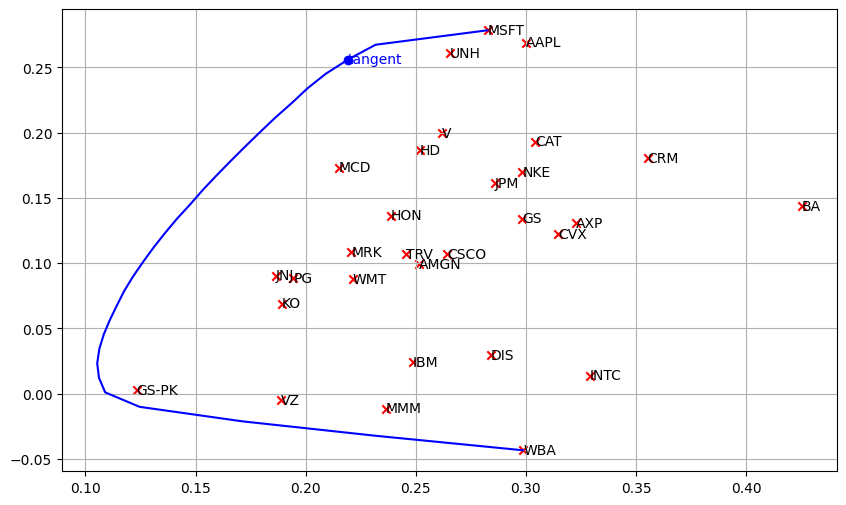

In [17]:
display_assets(names, R, C, color = 'black')
display_frontier(result_1, color = 'blue')

## Markowitz Portfolio Model

In [18]:
def load_SPY_data():
    #SP500 = pd.read_csv('dow-jones/SPY.csv')
    dataframe = pd.read_csv('dow-jones/SPY.csv', index_col = None, parse_dates = ['date'])
    spy_prices = list(dataframe['close'])[-2000:] # trailing window 2000 days
    print(spy_prices)
    return spy_prices

spy_prices = load_SPY_data()

[204.97000122070312, 205.4499969482422, 202.7400054931641, 200.13999938964844, 201.9900054931641, 199.4499969482422, 201.9199981689453, 204.83999633789065, 204.05999755859372, 206.1199951171875, 205.5500030517578, 204.6300048828125, 206.80999755859372, 206.92999267578125, 208.9199981689453, 209.77999877929688, 210.1100006103516, 210.1300048828125, 209.97999572753903, 211.2400054931641, 211.2100067138672, 211.80999755859372, 211.6300048828125, 211.3800048828125, 210.66000366210935, 211.9900054931641, 211.1199951171875, 210.22999572753903, 210.4600067138672, 207.5, 208.3600006103516, 204.97999572753903, 204.5, 207.1000061035156, 205.8300018310547, 208.5800018310547, 207.9600067138672, 210.4600067138672, 209.5, 210.41000366210935, 210.0, 208.82000732421875, 205.75999450683597, 205.2700042724609, 205.7400054931641, 208.25, 206.42999267578125, 205.6999969482422, 206.44000244140625, 207.8300018310547, 207.27999877929688, 207.97999572753903, 208.8999938964844, 210.0399932861328, 209.089996337

In [19]:
def SPY_market_return(spy_prices):
    # Convert the input stock prices into a numpy matrix
    spy_prices = np.matrix(spy_prices)
    r, c = spy_prices.shape

    # Create an empty numpy array to store historical returns
    historical_returns = np.empty([r, c-1])
    for ri in range(r):
        for ci in range(c-1):
            # Get the current price and the price from the previous day
            prior_price, after_price = spy_prices[ri, ci], spy_prices[ri, ci+1]
            historical_returns[ri, ci] = (after_price/prior_price)-1

    # Calculate the market variance of the historical returns
    market_variance = np.cov(historical_returns)

    # Calculate the annualized market return
    market_return = (1 + np.mean(historical_returns[0])) ** 253 - 1
    print(market_return)

    # Calculate the annualized market variance
    market_variance = market_variance * 253
    print(market_variance)
    
    # Calculate the volatility of the portfolio
    volatility = np.sqrt(market_variance)
    print(volatility)

    # Return the annualized market return and covariance
    return market_return, market_variance

market_return, market_variance = SPY_market_return(spy_prices)

0.10140784256867974
0.03516056106415772
0.187511495818677


In [20]:
def calculate_cov_matrix(stock_prices, spy_prices):
    # Convert prices to numpy matrices
    stock_prices = np.matrix(stock_prices)
    spy_prices = np.matrix(spy_prices)
    
    # Get number of rows and columns in stock_prices
    rows, cols = stock_prices.shape
    
    # Create empty matrices to store returns
    stock_returns = np.empty([rows, cols - 1])
    spy_returns = np.empty([rows, cols - 1])
    
    # Calculate returns
    for r in range(rows):
        for c in range(cols - 1):
            # Calculate stock returns
            p0, p1 = stock_prices[r, c], stock_prices[r, c + 1]
            stock_returns[r, c] = (p1 / p0) - 1
            
            # Calculate spy returns
            if r == 0:
                p2, p3 = spy_prices[r, c], spy_prices[r, c + 1]
                spy_returns[r, c] = (p3 / p2) - 1
    
    # Calculate covariance matrix
    cov_matrix = []
    for r in range(rows):
        covar = np.cov(stock_returns[r], spy_returns)[0, 1]
        cov_matrix.append(covar)
    
    # Annualize covariance matrix and return as numpy array
    return np.asarray(cov_matrix) * 253

In [21]:
# Covariance of each stock return with market return
cov_matrix = calculate_cov_matrix(prices, spy_prices)
beta = cov_matrix/market_variance
print(beta)

[0.83085545 1.22628579 1.22143333 1.4284734  1.05664751 1.05179016
 1.01807791 0.63472756 0.27432637 1.20388293 0.99600448 0.87271306
 1.20313542 0.58568924 1.14144191 0.71982371 1.05078952 0.61393043
 1.22498879 0.59707424 0.82881168 0.91861691 0.48116264 1.10618162
 0.53319981 0.84522246 1.01425628 0.78566514 0.98950626 1.24637569]


In [22]:
# def markowitz_model(R, C, W, market_return, rf, market_variance):
#     def util_function(W, R, market_return, rf):
#         mean_port = port_mean(R, W)
#         var_port = port_var(W, C)
#         print(var_port, market_variance)
#         result = rf + ((market_return - rf) * (np.sqrt(var_port) / np.sqrt(market_variance)))
#         return result
    
#     res = util_function(W, R, market_return, rf)

In [36]:
def markowitz_portfolio_return(result: Result, C, rf, market_return, market_variance):
    asset_std = np.sqrt(np.diag(C))
    market_std = np.sqrt(np.array([market_variance]))
    #print(asset_std)
    return rf + (market_return - rf) * (asset_std/market_std)

asset_return = markowitz_portfolio_return(result_1, C, rf, market_return, market_variance)

In [27]:
# def markowitz_portfolio_return(result: Result, C, rf, market_return, market_variance):
#     port_std = np.sqrt(np.array([port_var(result.W, C)]))
#     market_std = np.sqrt(np.array([market_variance]))
#     return rf + (market_return - rf) * (port_std/market_std)

# mark_return = markowitz_portfolio_return(result_1, C, rf, market_return, market_variance)

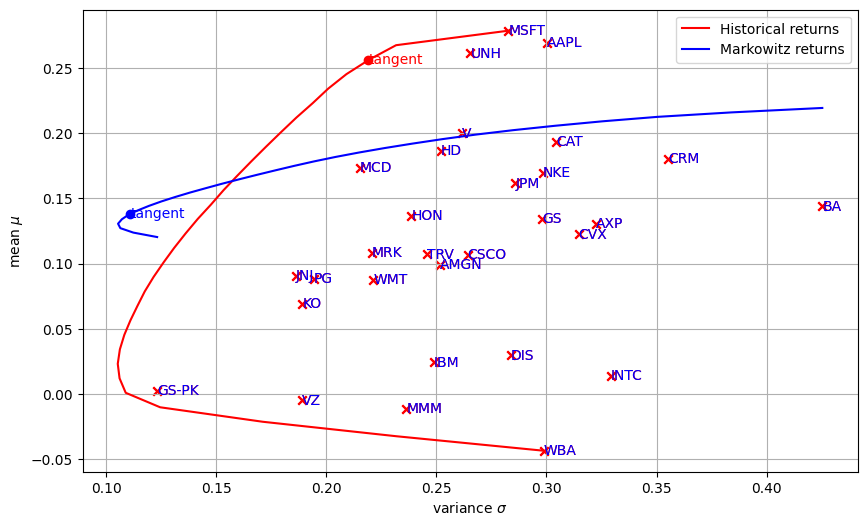

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,3.300730e-16,2.987819e-16,0.154478,2.562962e-18,0.018041,0.0,0.0,2.593201e-16,5.510298e-17,0.0,...,0.0,0.403607,0.0,0.0,5.703645e-17,9.488348e-17,0.0,1.111189e-16,0.0,0.0


In [40]:
res_mark = get_frontier(asset_return + rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(result_1, label='Historical returns', color='red')
display_assets(names, R, C, color = 'blue')
display_frontier(res_mark, label = 'Markowitz returns', color = 'blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': result_1.W}, index=names).T)

## Black-Litterman Reverse Optimization

In [30]:
# Calculate portfolio historical return and variance
mean = port_mean(R, W)
var = port_var(W, C)

lambdaa = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lambdaa, C), W)  # Calculate equilibrium excess returns
print(Pi + rf)

[0.14982311 0.19866027 0.23850765 0.22402627 0.17423888 0.17423958
 0.18490858 0.12515094 0.0773606  0.19603255 0.17607045 0.15717149
 0.21042141 0.12311598 0.1867023  0.14021849 0.18190063 0.12591938
 0.22941407 0.12615525 0.14692385 0.16933529 0.10485825 0.19591736
 0.11846053 0.15279513 0.17339916 0.14965929 0.16998396 0.21854439]
(30,)


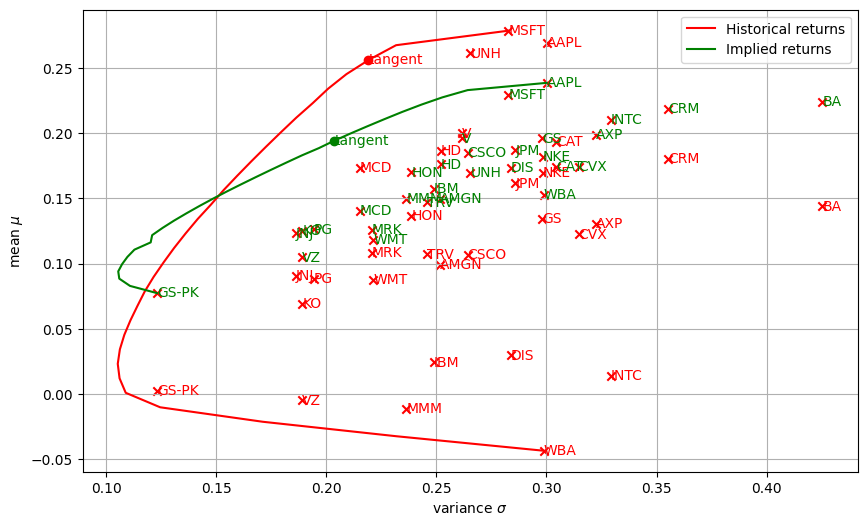

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.005131,0.010437,0.246711,0.011123,0.009969,0.027588,0.017264,0.025002,0.004987,0.009661,...,0.003823,0.041659,0.014578,0.044496,0.037688,0.002363,0.017053,0.011381,0.012133,0.018142


In [25]:
result_2 = get_frontier(Pi + rf, C, rf)

display_assets(names, R, C, color = 'red')
display_frontier(result_1, label = 'Historical returns', color = 'red')
display_assets(names, Pi + rf, C, color = 'green')
display_frontier(result_2, label = 'Implied returns', color = 'green')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': result_2.W}, index=names).T)